In [177]:
import pandas as pd

import matplotlib.pyplot as plt

In [178]:
df_pts =pd.read_csv('df_pts.csv', index_col=0)
df_sch = pd.read_csv('df_sch.csv', index_col=0)
df_tm = pd.read_csv('df_tm.csv', index_col=0)
df_tm1 = pd.read_csv('df_tm1.csv', index_col=0)

In [179]:
teams = df_tm.merge(df_tm1)

In [180]:
tm_owners = teams[['TeamID','Year','First','Last']]

In [181]:
total_matchups = df_pts.merge(tm_owners)


In [182]:
total_matchups['First'] = total_matchups['First'].str.capitalize()
total_matchups['Last'] = total_matchups['Last'].str.capitalize()

In [183]:
total_matchups.drop_duplicates(inplace=True)

In [184]:

total_matchups['Full Name'] = total_matchups['First'] + " "+ total_matchups['Last']

In [185]:
df_sch['Matchup_ID'] = df_sch['Year'].astype(str) + df_sch['Week'].astype(str)  + df_sch['HomeTeamId'].astype(str) + df_sch['AwayTeamId'].astype(str) 

In [186]:
df_sch_a = df_sch[['Year','Week','Matchup_ID','Type','AwayTeamId']].rename(columns={'AwayTeamId':'TeamID'})
df_sch_h = df_sch[['Year','Week','Matchup_ID','Type','HomeTeamId']].rename(columns={'HomeTeamId':'TeamID'})
df_sch_1 = pd.concat([df_sch_a,df_sch_h])

In [187]:
df_matchups = total_matchups.merge(df_sch_1,how='inner')

In [188]:
df_matchups['Actual_Winner'] = df_matchups.groupby('Matchup_ID')['Apts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['Optimal_Winner'] = df_matchups.groupby('Matchup_ID')['Opts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['ESPN_Winner'] = df_matchups.groupby('Matchup_ID')['Epts'].transform(lambda x: (x == x.max()).astype(int))

In [189]:

df_matchups_1 = df_matchups.loc[df_matchups['Full Name']!='Dave Miller']

In [190]:
df_matchups_1['Optimal_Missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Opts']
df_matchups_1['ESPN_missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Epts']

/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44747/1951970540.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44747/1951970540.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [191]:

df_matchups_1.loc[df_matchups_1['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [192]:
df_sorted = df_matchups_1.sort_values(by=['Matchup_ID', 'TeamID']).reset_index(drop=True)

# Shift the Apts column up and down to align with the opponent's values
df_sorted['Opponent_Apts'] = df_sorted['Apts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Apts'] = df_sorted['Apts'].shift(1)

df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

#df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
#df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

df_matchups_2 = df_matchups_1.merge(df_sorted)

In [193]:
df_Avg_Missed_Optimal = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts')

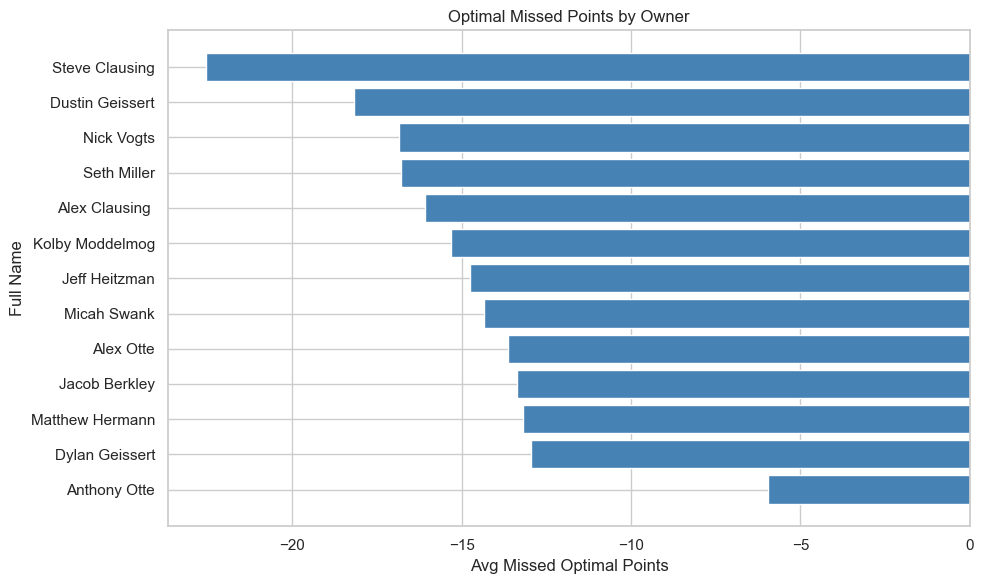

In [194]:
plt.figure(figsize=(10, 6))
plt.barh(df_Avg_Missed_Optimal['Full Name'], df_Avg_Missed_Optimal['Optimal_Missed_Pts'], color='steelblue')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Optimal Missed Points by Owner')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [195]:
df_ESPN_Mngr = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name'])["ESPN_missed_Pts"].mean().reset_index().sort_values(by='ESPN_missed_Pts')


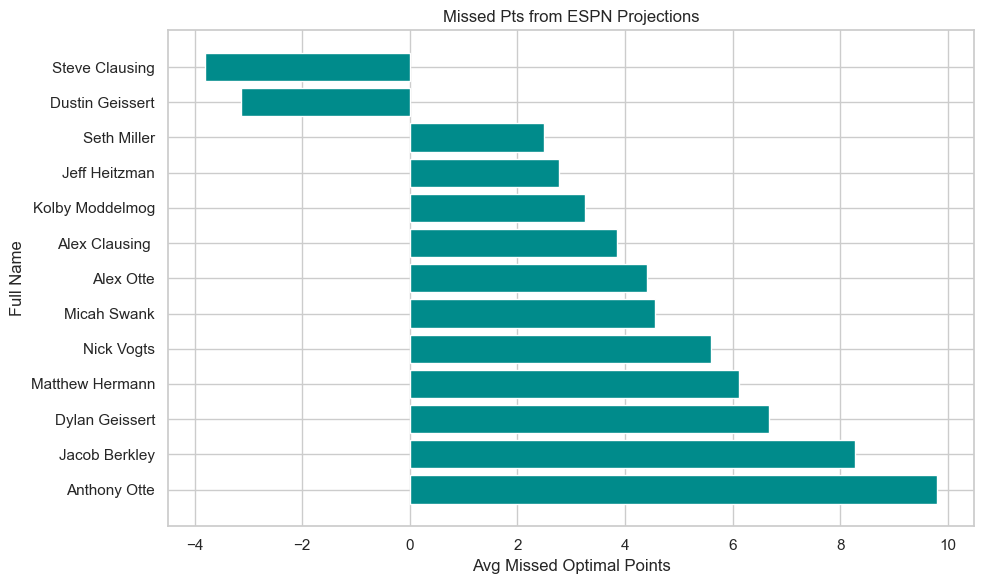

In [196]:
plt.figure(figsize=(10, 6))
plt.barh(df_ESPN_Mngr['Full Name'], df_ESPN_Mngr['ESPN_missed_Pts'], color='darkcyan')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Missed Pts from ESPN Projections')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [197]:
df_opts_season =df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name','Year'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts',ascending=False)


In [198]:
df_opts_wins = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)


In [199]:

df_Opts_Wins_Yrs = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name']).agg({
    'Opts': 'sum',
    'Actual_Winner': 'sum',
    'Optimal_Winner': 'sum',
    'Year': 'nunique',
    'Matchup_ID': 'count'}).reset_index()

In [200]:
df_Opts_Wins_Yrs['Opts/gm'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Matchup_ID']).round(1)
df_Opts_Wins_Yrs['Opts/yr'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Year']).round(1)
df_Opts_Wins_Yrs['Wins/yr'] = (df_Opts_Wins_Yrs['Actual_Winner']/df_Opts_Wins_Yrs['Year']).round(1)

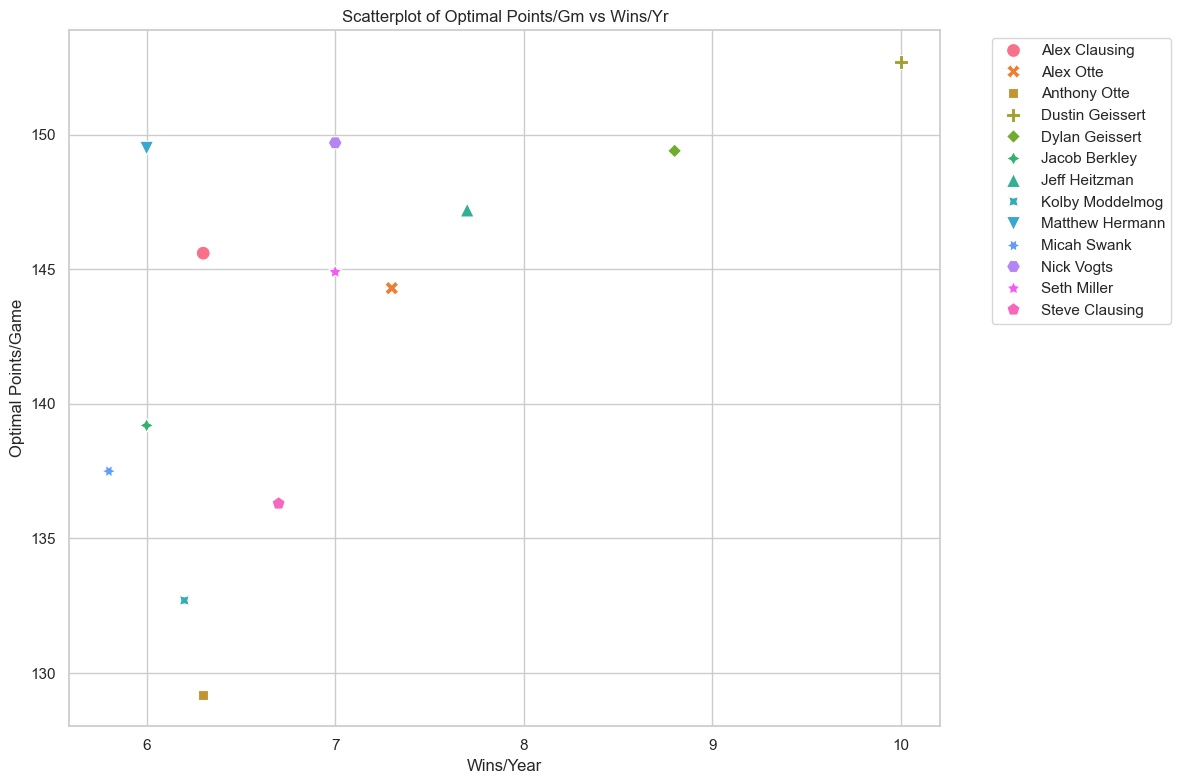

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_Opts_Wins_Yrs, x='Wins/yr', y='Opts/gm', hue='Full Name', style='Full Name', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points/Gm vs Wins/Yr')
plt.xlabel('Wins/Year')
plt.ylabel('Optimal Points/Game')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [202]:
df_opts_wins = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)



In [203]:

df_opts_wins['Name_Yr'] = df_opts_wins['Full Name']+"_"+df_opts_wins['Year'].astype("str")

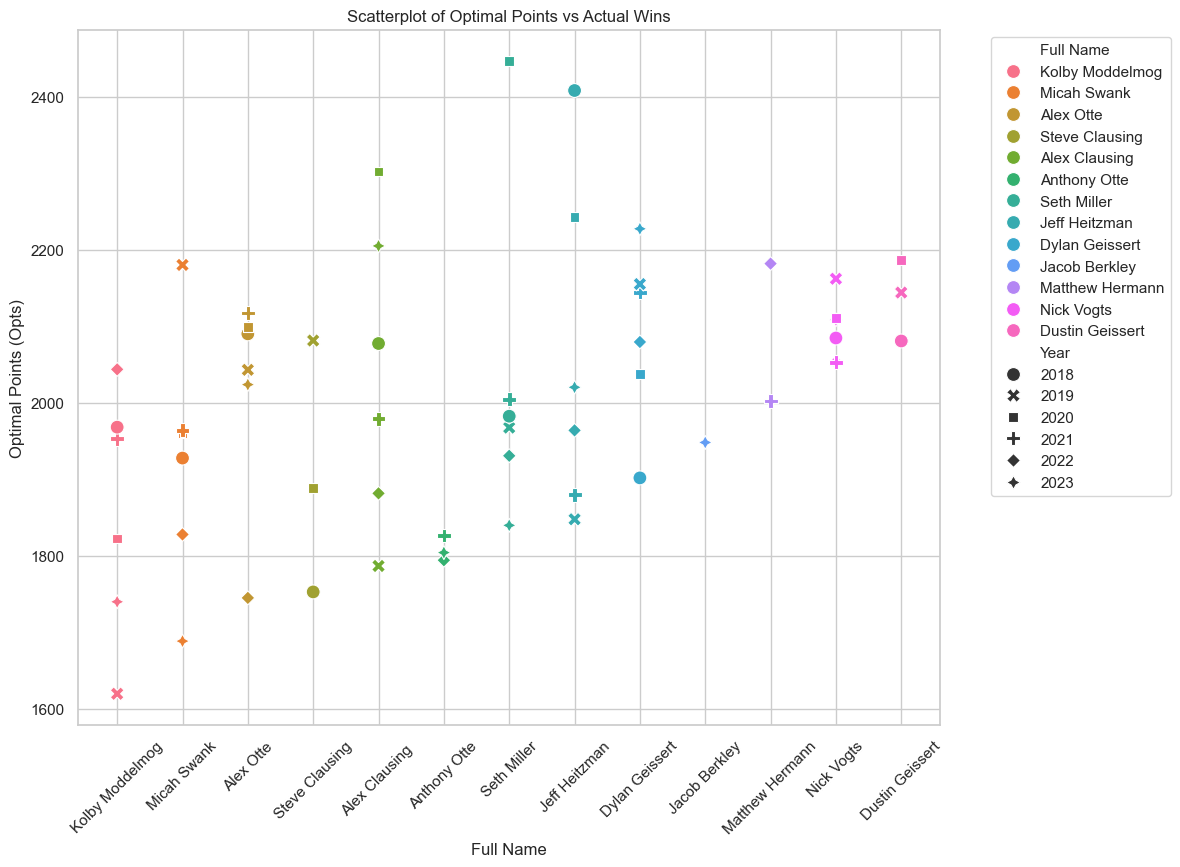

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_opts_wins, x='Full Name', y='Opts', hue='Full Name', style='Year', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Actual Wins')
plt.xlabel('Full Name')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()


In [205]:
#df_matchups_2

In [206]:
df_matchup_stats = df_matchups_2.loc[df_matchups_2['Type']=='Regular'].groupby(['Full Name',"Year"]).agg({
    'Optimal_Missed_Pts': 'sum',
    'Opts': 'sum',
    'Apts': 'sum',
    'Opponent_Opts': 'sum',
    'Opponent_Apts': 'sum',
    'Actual_Winner': 'sum',
    'Optimal_Winner': 'sum',
    'ESPN_Winner': 'sum',
    'Matchup_ID': 'count'}).reset_index()

In [207]:

df_matchup_stats['Adjusted_Wins'] = df_matchup_stats['Optimal_Winner']-df_matchup_stats['Actual_Winner']

In [208]:

df_matchup_stats['Name_Year'] = df_matchup_stats['Full Name'] + ' ' + df_matchup_stats['Year'].astype(str)

In [209]:

df_matchup_stats.sort_values(by='Adjusted_Wins', inplace=True)

In [210]:
df_mstats_short = df_matchup_stats.loc[(df_matchup_stats['Adjusted_Wins']>1)|(df_matchup_stats['Adjusted_Wins']< -1)]


In [211]:
#df_matchup_stats

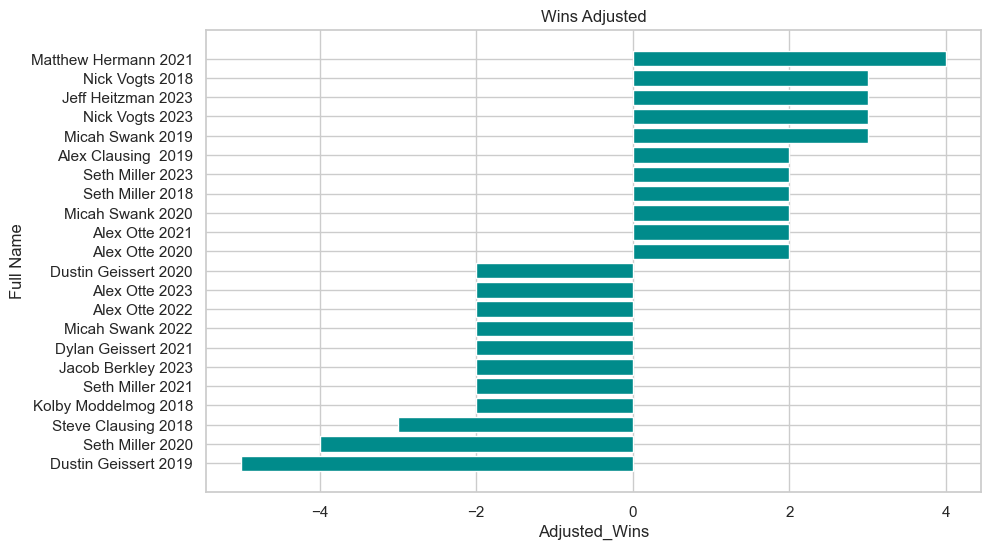

In [212]:
plt.figure(figsize=(10, 6))
plt.barh(df_mstats_short['Name_Year'], df_mstats_short['Adjusted_Wins'], color='darkcyan')
plt.xlabel('Adjusted_Wins')
plt.ylabel('Full Name')
plt.title('Wins Adjusted')
#plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
#plt.tight_layout()

# Show plot
plt.show()

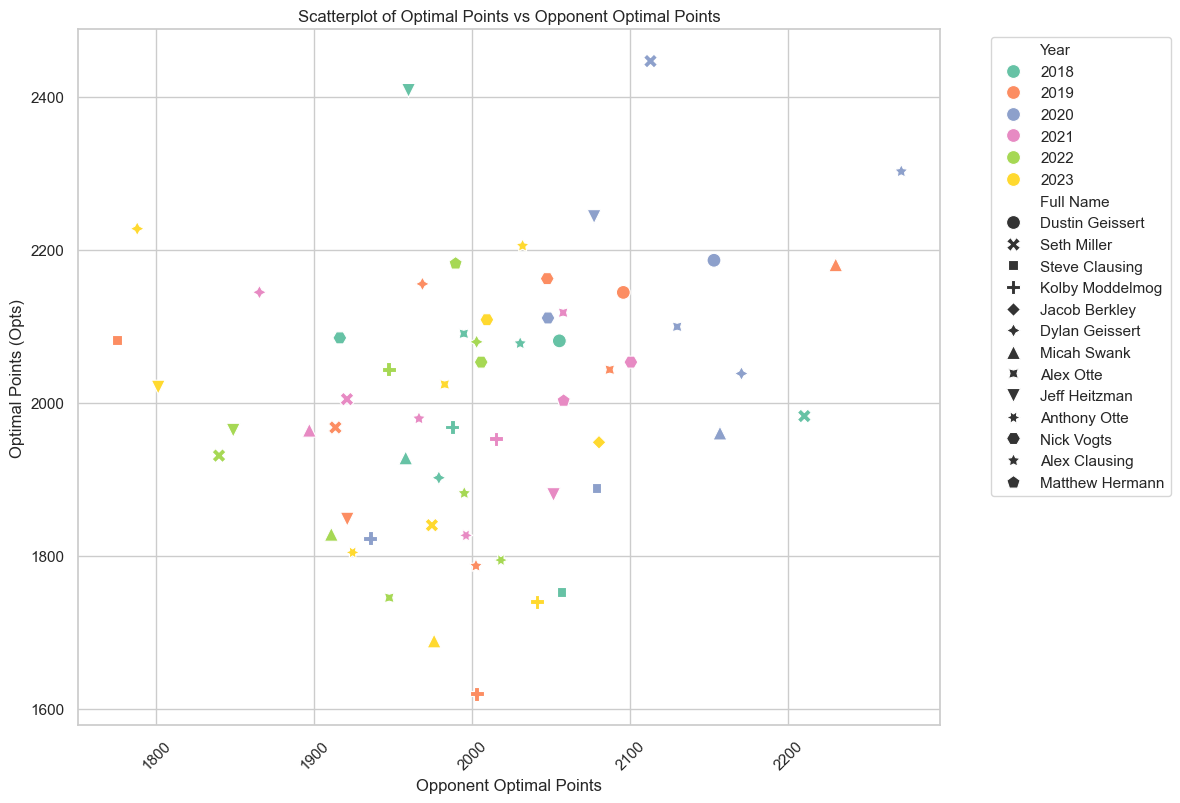

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Opponent_Opts', y='Opts', hue='Year', style='Full Name', s=100, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Opponent Optimal Points')
plt.xlabel('Opponent Optimal Points')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [214]:
df_matchup_stats['Year'] = df_matchup_stats['Year'].astype("str")

In [215]:
yearly_avg = df_matchup_stats.groupby('Year')['Opponent_Opts'].mean().reset_index().rename(columns={'Opponent_Opts': 'Yearly_Avg_Opponent_Opts'})

In [216]:
df_matchup_stats = df_matchup_stats.merge(yearly_avg, on='Year')

In [217]:
df_matchup_stats['Diff_Opponent_Opts'] = df_matchup_stats['Opponent_Opts'] - df_matchup_stats['Yearly_Avg_Opponent_Opts']

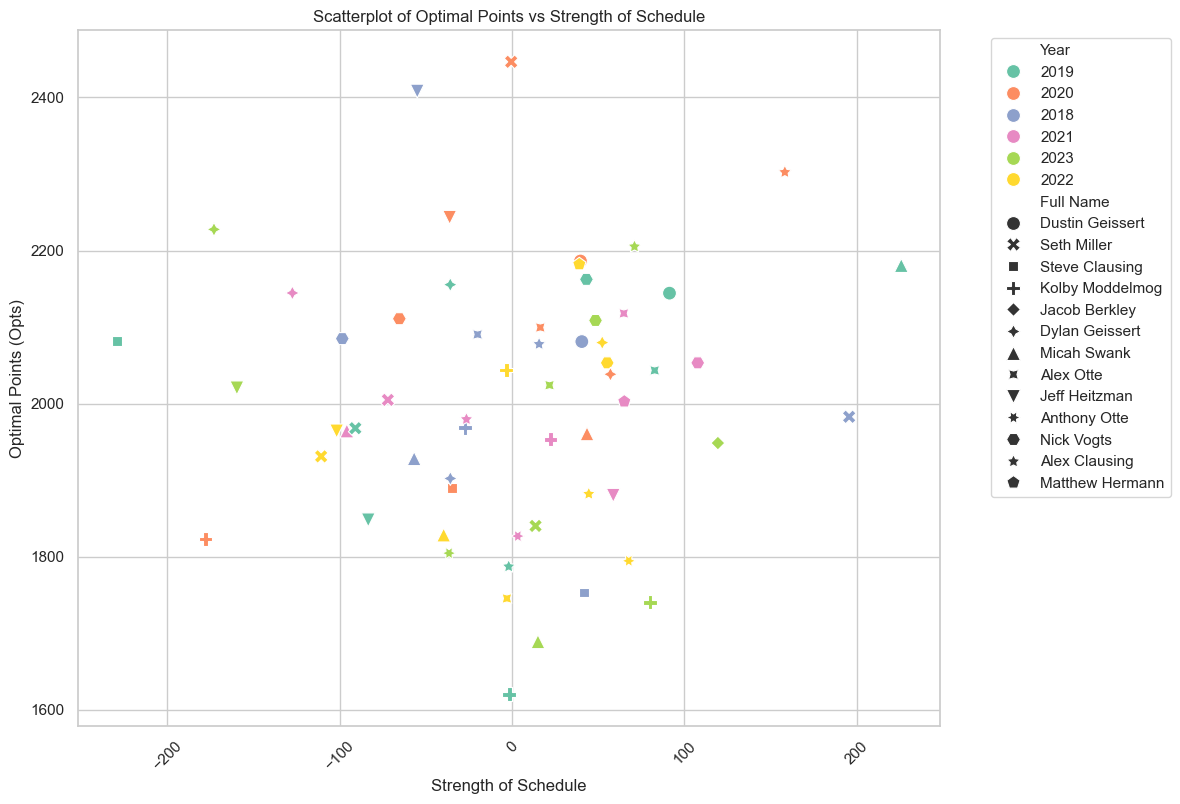

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Diff_Opponent_Opts', y='Opts', hue='Year', style='Full Name', s=100, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Strength of Schedule')
plt.xlabel('Strength of Schedule')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [219]:
df_matchup_stats['Extra_Pts_Against/Game'] = df_matchup_stats['Diff_Opponent_Opts']/df_matchup_stats['Matchup_ID']

In [220]:
df_SoS = df_matchup_stats.groupby(['Full Name'])['Diff_Opponent_Opts'].sum().reset_index().sort_values(by='Diff_Opponent_Opts')

In [221]:
df_SoS_Yrs = df_Opts_Wins_Yrs.merge(df_SoS)

In [222]:
df_SoS_Yrs['Extra_Pts_Against/Game'] = df_SoS_Yrs['Diff_Opponent_Opts']/df_SoS_Yrs['Matchup_ID']

In [252]:
#df_matchup_stats

In [223]:
df_SoS_Yrs.loc[df_SoS_Yrs['Full Name']!='Jacob Berkley']

,Full Name,Opts,Actual_Winner,Optimal_Winner,Year,Matchup_ID,Opts/gm,Opts/yr,Wins/yr,Diff_Opponent_Opts,Extra_Pts_Against/Game
0,Alex Clausing,12233.7,38,40,6,84,145.6,2039.0,6.3,260.99,3.107024
1,Alex Otte,12120.1,44,44,6,84,144.3,2020.0,7.3,162.59,1.935595
2,Anthony Otte,5425.8,19,17,3,42,129.2,1808.6,6.3,34.42,0.819524
3,Dustin Geissert,6411.6,30,22,3,42,152.7,2137.2,10.0,171.47,4.082619
4,Dylan Geissert,12547.6,53,51,6,84,149.4,2091.3,8.8,-262.81,-3.128690
6,Jeff Heitzman,12364.5,46,49,6,84,147.2,2060.8,7.7,-377.51,-4.494167
7,Kolby Moddelmog,11148.7,37,34,6,84,132.7,1858.1,6.2,-107.71,-1.282262
8,Matthew Hermann,4184.9,12,16,2,28,149.5,2092.4,6.0,104.11,3.718214
9,Micah Swank,11550.1,35,38,6,84,137.5,1925.0,5.8,91.89,1.093929
10,Nick Vogts,12573.1,42,48,6,84,149.7,2095.5,7.0,90.49,1.077262


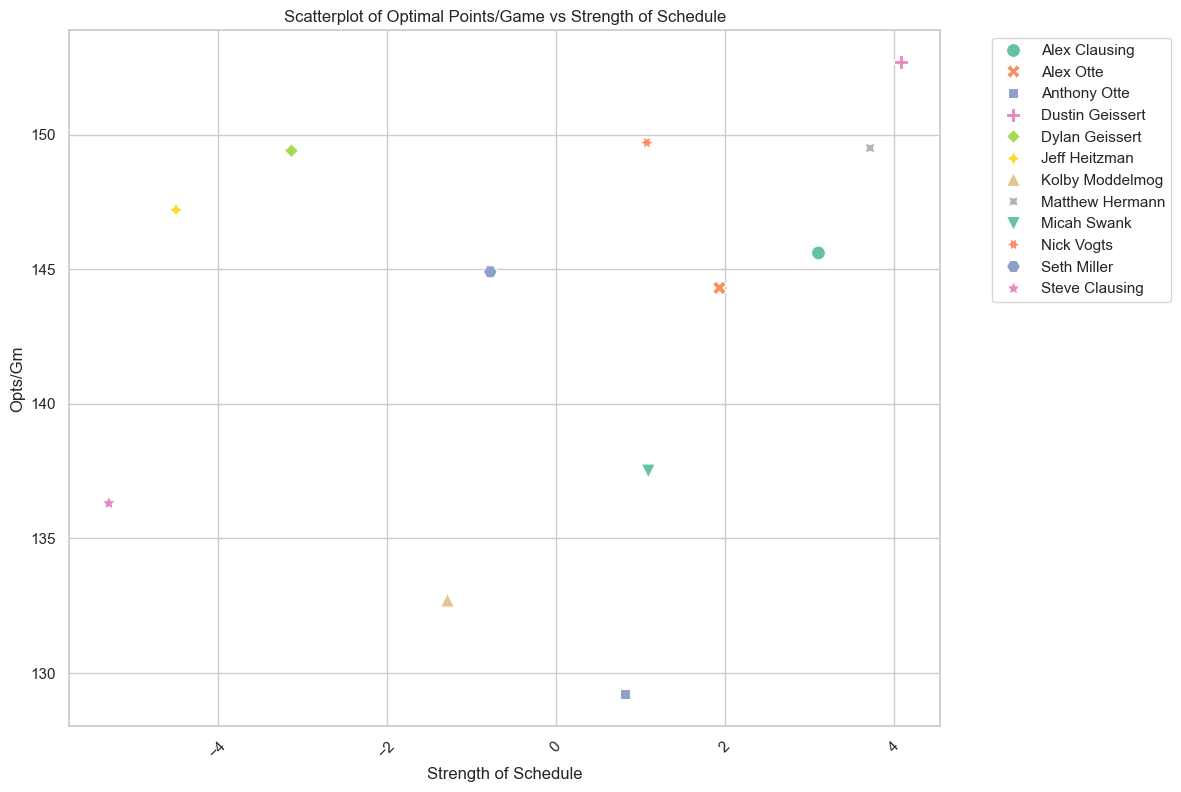

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_SoS_Yrs.loc[df_SoS_Yrs['Full Name']!='Jacob Berkley'], x='Extra_Pts_Against/Game', y='Opts/gm', hue='Full Name', style='Full Name', s=100, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Optimal Points/Game vs Strength of Schedule')
plt.xlabel('Strength of Schedule')
plt.ylabel('Opts/Gm')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [225]:
df_SoS_Yrs['Win_Percentage'] = ((df_SoS_Yrs['Actual_Winner']/df_SoS_Yrs['Matchup_ID'])*100).round(2)
df_SoS_Yrs['Optimal_Win_Percentage'] = ((df_SoS_Yrs['Optimal_Winner']/df_SoS_Yrs['Matchup_ID'])*100).round(2)

In [226]:
df_SoS_Yrs

,Full Name,Opts,Actual_Winner,Optimal_Winner,Year,Matchup_ID,Opts/gm,Opts/yr,Wins/yr,Diff_Opponent_Opts,Extra_Pts_Against/Game,Win_Percentage,Optimal_Win_Percentage
0,Alex Clausing,12233.7,38,40,6,84,145.6,2039.0,6.3,260.99,3.107024,45.24,47.62
1,Alex Otte,12120.1,44,44,6,84,144.3,2020.0,7.3,162.59,1.935595,52.38,52.38
2,Anthony Otte,5425.8,19,17,3,42,129.2,1808.6,6.3,34.42,0.819524,45.24,40.48
3,Dustin Geissert,6411.6,30,22,3,42,152.7,2137.2,10.0,171.47,4.082619,71.43,52.38
4,Dylan Geissert,12547.6,53,51,6,84,149.4,2091.3,8.8,-262.81,-3.128690,63.10,60.71
5,Jacob Berkley,1948.4,6,4,1,14,139.2,1948.4,6.0,119.41,8.529286,42.86,28.57
6,Jeff Heitzman,12364.5,46,49,6,84,147.2,2060.8,7.7,-377.51,-4.494167,54.76,58.33
7,Kolby Moddelmog,11148.7,37,34,6,84,132.7,1858.1,6.2,-107.71,-1.282262,44.05,40.48
8,Matthew Hermann,4184.9,12,16,2,28,149.5,2092.4,6.0,104.11,3.718214,42.86,57.14
9,Micah Swank,11550.1,35,38,6,84,137.5,1925.0,5.8,91.89,1.093929,41.67,45.24


/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44747/743508007.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44747/743508007.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




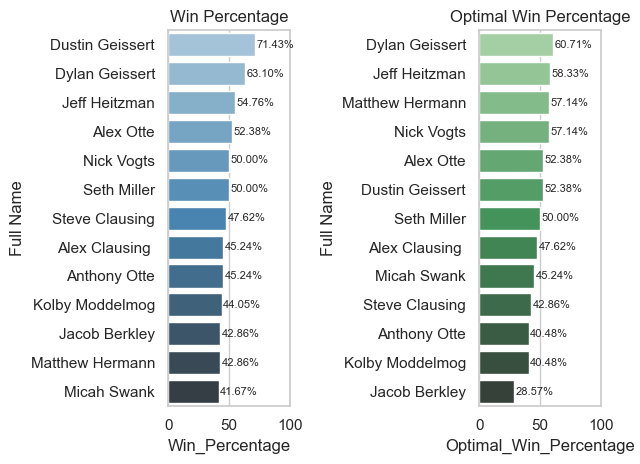

In [227]:
# Create the first subplot for Win Percentage
plt.subplot(1, 2, 1)
sns.barplot(x='Win_Percentage', y='Full Name', data=df_SoS_Yrs.sort_values(by="Win_Percentage",ascending=False), palette='Blues_d')
plt.title('Win Percentage')

plt.xlim(0, 100)

# Add percentage labels on the bars
for index, value in enumerate(df_SoS_Yrs.sort_values(by="Win_Percentage",ascending=False)['Win_Percentage']):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=8)

# Create the second subplot for Optimal Win Percentage
plt.subplot(1, 2, 2)
sns.barplot(x='Optimal_Win_Percentage', y='Full Name', data=df_SoS_Yrs.sort_values(by="Optimal_Win_Percentage",ascending=False), palette='Greens_d')
plt.title('Optimal Win Percentage')

plt.xlim(0, 100)

# Add percentage labels on the bars
for index, value in enumerate(df_SoS_Yrs.sort_values(by="Optimal_Win_Percentage",ascending=False)['Optimal_Win_Percentage']):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=8)


# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()

In [228]:
df_matchup_stats['Opponenet Realized Pts %'] = ((df_matchup_stats['Opponent_Apts']/df_matchup_stats['Opponent_Opts'])*100).round(2)

In [229]:
df_matchup_stats['Realized Pts %'] = ((df_matchup_stats['Apts']/df_matchup_stats['Opts'])*100).round(2)

In [233]:
#df_matchup_stats

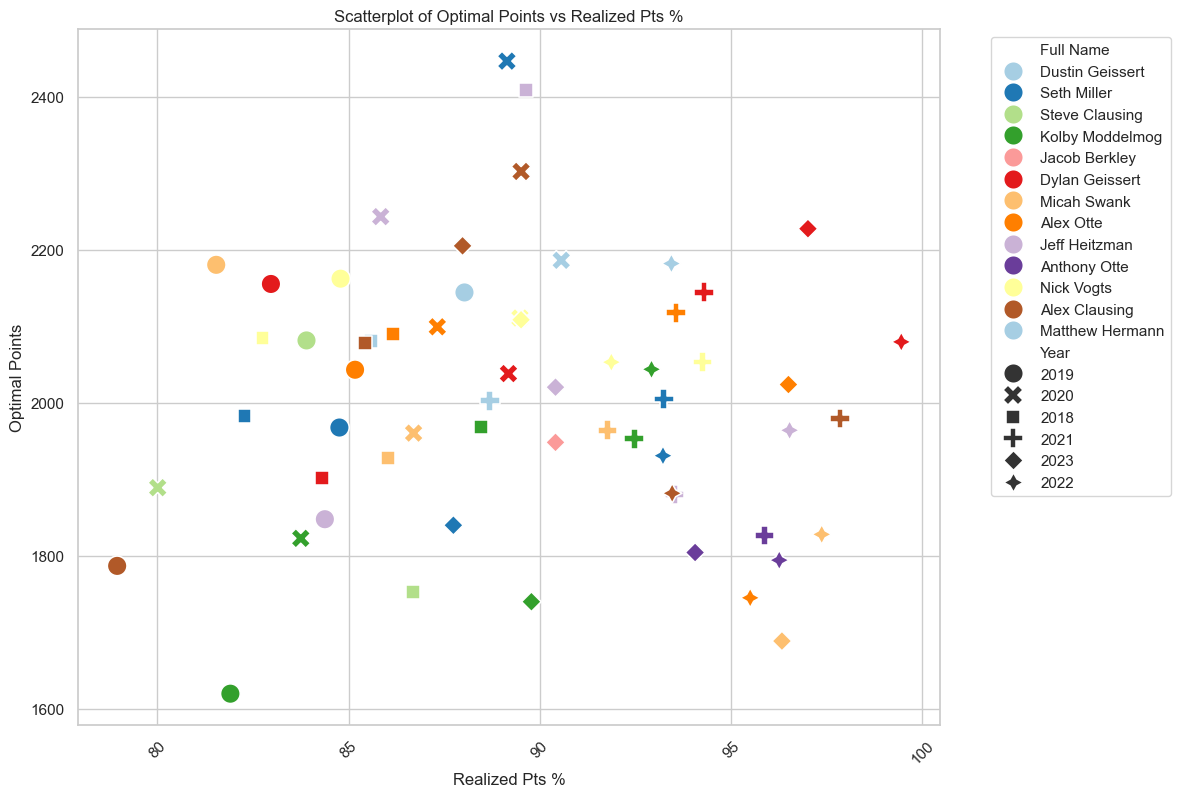

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.set_palette("Paired",14)

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Realized Pts %', y='Opts', hue='Full Name', style='Year', s=200)

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Realized Pts %')
plt.xlabel('Realized Pts %')
plt.ylabel('Optimal Points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

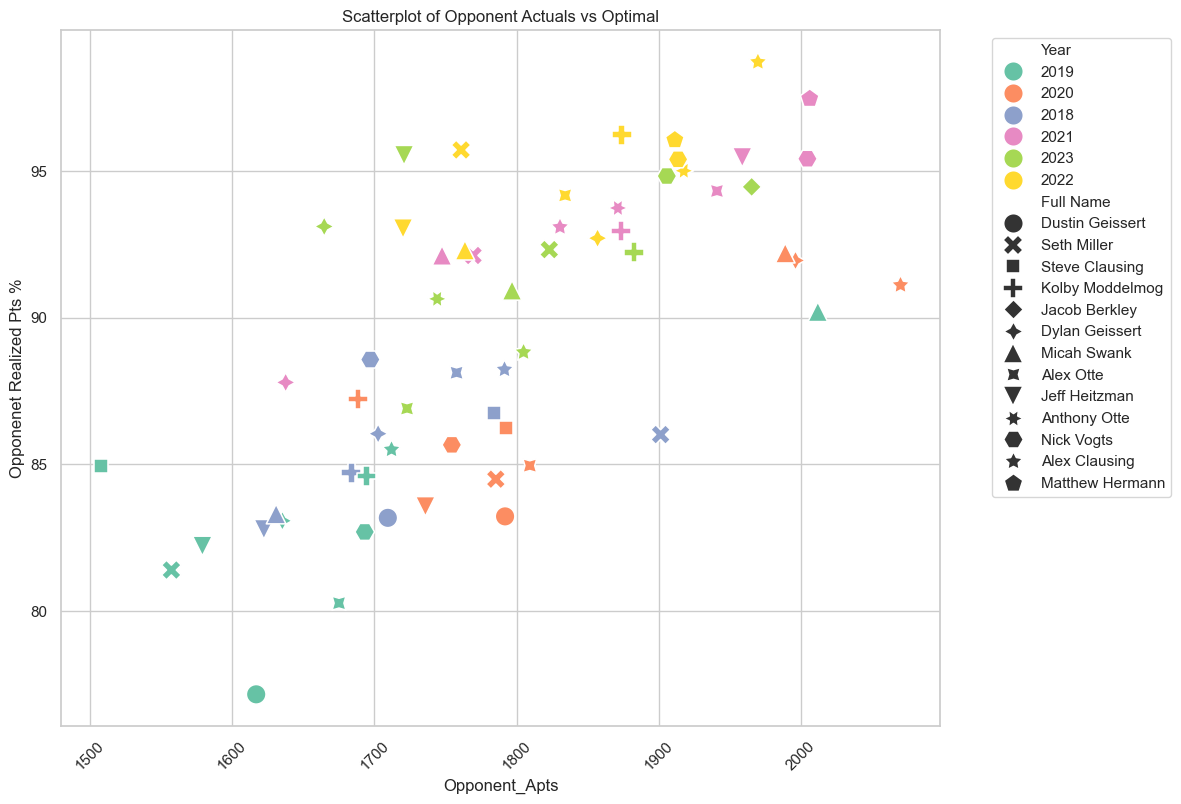

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Opponent_Apts', y='Opponenet Realized Pts %', hue='Year', style='Full Name', s=200, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Opponent Actuals vs Optimal')
plt.xlabel('Opponent_Apts')
plt.ylabel('Opponenet Realized Pts %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()